# CRISPR-screens pilot analysis

In [3]:
# load required libraries
import pandas as pd
import numpy as np
import copy
from scipy.stats.stats import pearsonr  
import seaborn as sns
import matplotlib.pyplot as plt

In [4]:
df = pd.read_csv("data/DEM_rand1.readcounts")
df.head()

,Name,Gene,CTRL Replicate 1,CTRL Replicate 2,TEST Replicate 1,TEST Replicate 2
0,None_001,None,230,220,253,212
1,None_002,None,278,288,264,309
2,None_003,None,80,70,57,59
3,None_004,None,208,200,212,192
4,None_005,None,107,108,106,115


In [5]:
# rows check
len(df)

12334

In [6]:
# unique genes in the library
unique_genes = np.unique(df[["Gene"]])
len(unique_genes) # 1095
unique_genes

array(['GENE0001', 'GENE0002', 'GENE0003', ..., 'GENE1093', 'None',
       'Safe'], dtype=object)

**Check correlation between replicates**

In [7]:
# get column names
cols = df.columns

# control 
ctrl1 = np.array(df[cols[2]])
ctrl2 = np.array(df[cols[3]])
c_corr = pearsonr(ctrl1, ctrl2)[0]
# correlation between control replicates
print(f'Correlation between control replicates is {round(c_corr, 4)}')

# test
test1 = np.array(df[cols[4]])
test2 = np.array(df[cols[5]])
t_corr = pearsonr(test1, test2)[0]
# correlation between test replicates
print(f'Correlation between test replicates is {round(t_corr, 4)}')

Correlation between control replicates is 0.9826
Correlation between test replicates is 0.9594


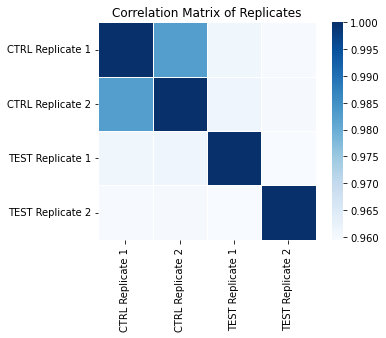

In [8]:
# visualizing the correlations altogether
corrMat = df.corr()
corrPlot = sns.heatmap(corrMat, linewidths=1, square=True, cmap='Blues')
plt.title('Correlation Matrix of Replicates')
plt.show()

**Normalization**

In [10]:
def cpm(data_frame, control_prefix='CTRL', test_prefix='TEST'):
    """Calculate read counts per 10 million reads given by,
    CPM = (C / S) * 10^7
    
    Where:
    C = read counts (values) 
    S = Column-sum 

    @param: counts, read counts for single replicate
    @return: n_counts, normalized counts
    """
    # sum each column to get total reads per sample
    for column in data_frame.columns:
        if control_prefix in column or test_prefix in column:
            scaling_factor = 1e7 / (data_frame[column].sum() / 2)
            data_frame[column] *= scaling_factor
    return data_frame

In [30]:
# apply the cpm function on each replicate
df_screens = copy.deepcopy(df)
df_norm = cpm(df_screens)
df_norm.head()

,Name,Gene,CTRL Replicate 1,CTRL Replicate 2,TEST Replicate 1,TEST Replicate 2
0,None_001,None,2794.079952,2669.255035,3070.554174,2581.941632
1,None_002,None,3377.192290,3494.297501,3204.056530,3763.301719
2,None_003,None,971.853896,849.308420,691.784933,718.559228
3,None_004,None,2526.820130,2426.595487,2572.954486,2338.362233
4,None_005,None,1299.854586,1310.361563,1286.477243,1400.581546


The data transformation to counts per 10 million reads has a crucial effect on creating a relative measure across all genes, ensuring a unified scale that mitigates bias from technical or non-technical errors. This normalization is essential for meaningful comparisons between replicates with varying sequencing depths. Additionally, the approach helps prevent skewness and/or one-sided variance in the data. To assess reproducibility, drawing distribution curves is a valuable preliminary step, aiding in the detection of outliers during the pre-processing stage. Overall, the transformation enhances the interpretability and reliability of genomics data for downstream analyses.

**Average Log2FC**

In [27]:
def calculate_average_log2fc(data_frame, control_prefix='CTRL', test_prefix='TEST'):
    """
    Calculate the average Log2FC for each gene based on control and test columns

    Parameters:
        data_frame (DataFrame): Input df containing gene expression data
        control_prefix (str): Prefix for control columns
        test_prefix (str): Prefix for test columns

    Returns:
        DataFrame: df with calculated Log2FC values and average Log2FC for each gene
    """
    # Identify control and test columns
    control_columns = [col for col in data_frame.columns if control_prefix in col]
    test_columns = [col for col in data_frame.columns if test_prefix in col]

    # Calculate Log2FC for each replicate
    for i in range(len(control_columns)):
        data_frame[f'Log2FC_Replicate_{i+1}'] = np.log2(data_frame[test_columns[i]] / data_frame[control_columns[i]])

    # Calculate average Log2FC for each replicate
    data_frame['Average_Log2FC'] = data_frame.filter(like='Log2FC_Replicate').mean(axis=1)

    return data_frame

In [32]:
df_log2fc = calculate_average_log2fc(df_norm)

In [34]:
df_log2fc.head()

,Name,Gene,CTRL Replicate 1,CTRL Replicate 2,TEST Replicate 1,TEST Replicate 2,Log2FC_Replicate_1,Log2FC_Replicate_2,Average_Log2FC
0,None_001,None,2794.079952,2669.255035,3070.554174,2581.941632,0.136126,-0.047981,0.044072
1,None_002,None,3377.192290,3494.297501,3204.056530,3763.301719,-0.075925,0.106997,0.015536
2,None_003,None,971.853896,849.308420,691.784933,718.559228,-0.490416,-0.241181,-0.365799
3,None_004,None,2526.820130,2426.595487,2572.954486,2338.362233,0.026103,-0.053435,-0.013666
4,None_005,None,1299.854586,1310.361563,1286.477243,1400.581546,-0.014924,0.096061,0.040568


The Log2FC values have been calculated for each replicate by taking the logarithm base 2 of the ratio between the expression levels in the test condition and the control condition. The positive Log2FC values indicate an increase in gene expression in the test condition compared to the control, while negative values suggest a decrease. The average Log2FC across replicates provides a consolidated measure of expression change, offering insights into the overall directional trend of gene expression alterations in response to the experimental conditions. The Log2FC metric is commonly used to assess the magnitude of expression changes on a logarithmic scale, facilitating interpretability and comparability across different genes.

**Plotting histogram for all Log2FC values**

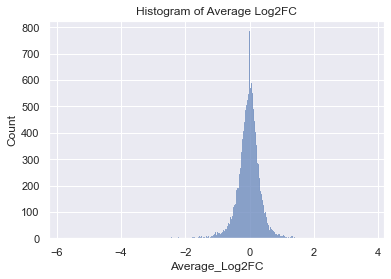

In [35]:
sns.set(style="darkgrid")
sns.histplot(df_log2fc, x="Average_Log2FC")
plt.title('Histogram of Average Log2FC')
plt.show()

The histogram illustrates the distribution of average Log2FC values. It provides a quick overview of the overall expression changes, indicating whether genes are predominantly upregulated, downregulated, or exhibit minimal changes. The plot helps identify the central tendency and spread of the data, offering insights into the differential expression patterns across genes or condition.


**A metric to compare the LFCs of all elements associated with a gene compared to the LFC of all 'Safe' elements**


In [50]:
def calculate_metric(data_frame, control_prefix='CTRL', test_prefix='TEST', safe_label='Safe'):
    
    control_columns = [col for col in data_frame.columns if control_prefix in col]
    test_columns = [col for col in data_frame.columns if test_prefix in col]

    for control_col, test_col in zip(control_columns, test_columns):
        data_frame[f'Log2FC_{control_col.replace(control_prefix, "")}'] = np.log2(data_frame[test_col] / data_frame[control_col])

    data_frame['Average_Log2FC'] = data_frame.filter(like='Log2FC').mean(axis=1)

    # Calculate average Log2FC for 'Safe' elements
    safe_mask = data_frame['Gene'] == safe_label
    avg_log2fc_safe = data_frame.loc[safe_mask, 'Average_Log2FC'].mean()

    # Calculate the metric: Difference between gene and 'Safe'
    data_frame['Metric'] = data_frame['Average_Log2FC'] - avg_log2fc_safe

    return data_frame[['Name', 'Gene', 'Average_Log2FC', 'Metric']]

In [36]:
def calculate_relative_log2fc(data_frame, gene_column='Gene', log2fc_column='Average_Log2FC', safe_label='Safe'):
    """
    Calculate the relative Log2FC for each gene compared to the Log2FC of 'Safe' elements

    Parameters:
        data_frame (pd.DataFrame): Input df containing gene expression data
        gene_column (str): gene labels
        log2fc_column (str):  averageLog2FC values
        safe_label (str): Label indicating 'Safe' elements

    Returns:
        DataFrame: Updated df with the 'Relative_Log2FC' column
    """
    # Calculate average Log2FC for 'Safe' elements
    avg_log2fc_safe = data_frame[data_frame[gene_column] == safe_label][log2fc_column].mean()

    # Calculate the relative Log2FC for each gene
    data_frame['Relative_Log2FC'] = data_frame[log2fc_column] - avg_log2fc_safe

    return data_frame

In [37]:
df_relativeL2FC = calculate_relative_log2fc(df_log2fc)

In [38]:
df_relativeL2FC.head()

,Name,Gene,CTRL Replicate 1,CTRL Replicate 2,TEST Replicate 1,TEST Replicate 2,Log2FC_Replicate_1,Log2FC_Replicate_2,Average_Log2FC,Relative_Log2FC
0,None_001,None,2794.079952,2669.255035,3070.554174,2581.941632,0.136126,-0.047981,0.044072,0.095830
1,None_002,None,3377.192290,3494.297501,3204.056530,3763.301719,-0.075925,0.106997,0.015536,0.067293
2,None_003,None,971.853896,849.308420,691.784933,718.559228,-0.490416,-0.241181,-0.365799,-0.314042
3,None_004,None,2526.820130,2426.595487,2572.954486,2338.362233,0.026103,-0.053435,-0.013666,0.038091
4,None_005,None,1299.854586,1310.361563,1286.477243,1400.581546,-0.014924,0.096061,0.040568,0.092325


The Relative Log2FC metric is designed to provide a comparative measure of expression changes for each gene in relation to a baseline represented by the 'Safe' elements. By calculating the difference between the Log2FC of each gene and the average Log2FC of the 'Safe' elements, the metric offers insights into how individual genes deviate from the overall expression changes observed in the 'Safe' elements. A positive value indicates that a gene has, on average, higher expression changes compared to the 'Safe' elements, while a negative value suggests lower expression changes. This metric helps identify genes with distinctive expression patterns relative to the chosen baseline, aiding in the interpretation of their biological significance in the context of the experimental conditions.

In [39]:
data = copy.deepcopy(df_relativeL2FC)

In [43]:
# Comparing the top five genes with the most negative LFC compared to "Safe" 
# Exclude the 'Safe' element from consideration
top_negative_genes = data[data['Gene'] != 'Safe'].nlargest(5, 'Average_Log2FC')
top_negative_genes[['Gene', 'Average_Log2FC', 'Relative_Log2FC']]

,Gene,Average_Log2FC,Relative_Log2FC
11908,GENE1051,3.698199,3.749956
6562,GENE0512,3.247967,3.299724
8972,GENE0755,3.193774,3.245531
7177,GENE0574,2.648431,2.700188
3832,GENE0235,2.633558,2.685315


In [42]:
# comparing the top five genes with the most positive LFC compared to "Safe"
top_positive_genes = data[data['Gene'] != 'Safe'].nsmallest(5, 'Average_Log2FC')
top_positive_genes[['Gene', 'Average_Log2FC', 'Relative_Log2FC']]

,Gene,Average_Log2FC,Relative_Log2FC
1834,GENE0034,-5.760358,-5.708601
5521,GENE0406,-4.239630,-4.187873
11706,GENE1030,-4.147564,-4.095807
12072,GENE1067,-4.140451,-4.088693
8244,GENE0681,-4.126654,-4.074897


**Verifying the findings by plotting the L2FCs of your selected genes against the same number of random "Safe" L2FCs**

In [45]:
# Generate random "Safe" Log2FCs for comparison
random_safe_log2fc = np.random.normal(0, 0.5, 5)

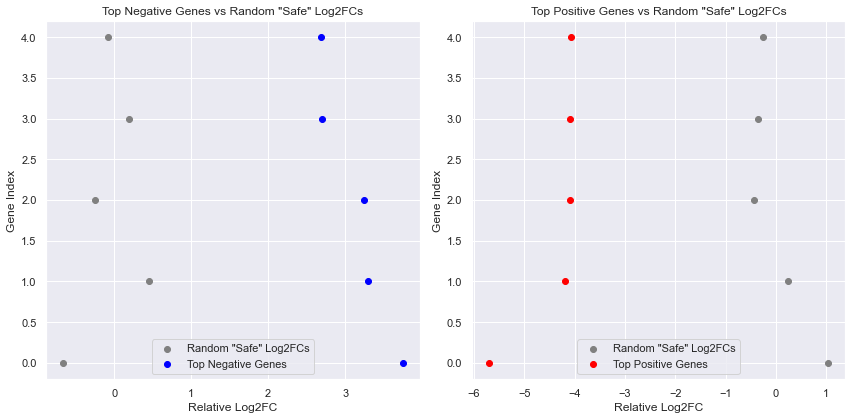

In [49]:
# Generate random "Safe" Log2FCs for comparison
random_safe_log2fc = np.random.normal(0, 0.5, len(top_negative_genes) + len(top_positive_genes))

# Plot separate scatter plots for positive and negative genes
plt.figure(figsize=(12, 6))

# Scatter plot for top negative genes
plt.subplot(1, 2, 1)
plt.scatter(random_safe_log2fc[:len(top_negative_genes)], range(len(top_negative_genes)), label='Random "Safe" Log2FCs', color='gray')
plt.scatter(top_negative_genes['Relative_Log2FC'], range(len(top_negative_genes)), label='Top Negative Genes', color='blue')
plt.title('Top Negative Genes vs Random "Safe" Log2FCs')
plt.xlabel('Relative Log2FC')
plt.ylabel('Gene Index')
plt.legend()

# Scatter plot for top positive genes
plt.subplot(1, 2, 2)
plt.scatter(random_safe_log2fc[len(top_negative_genes):], range(len(top_positive_genes)), label='Random "Safe" Log2FCs', color='gray')
plt.scatter(top_positive_genes['Relative_Log2FC'], range(len(top_positive_genes)), label='Top Positive Genes', color='red')
plt.title('Top Positive Genes vs Random "Safe" Log2FCs')
plt.xlabel('Relative Log2FC')
plt.ylabel('Gene Index')
plt.legend()

plt.tight_layout()
plt.show()

The scatter plots effectively illustrate the distribution and relationships of Log2FC values, providing insights into the expression changes of selected genes compared to random "Safe" Log2FCs. In the left subplot, the blue points represent the Log2FCs of the top negative genes, while the right subplot displays the Log2FCs of the top positive genes in red. The gray points represent randomly generated "Safe" Log2FCs for reference.

Observing the scatter plots reveals how the Log2FCs of the selected genes align with or deviate from the distribution of "Safe" Log2FCs. A clear separation or clustering of points for the selected genes compared to the random distribution would suggest distinct expression patterns. This visual analysis enhances the interpretation of the selected genes' significance in relation to the overall expression changes observed in the dataset.
